- Importar bibliotecas necessárias (OK)
- Separar as variaveis dependentes das variaveis independentes em ambos os datasets (treino e teste) - após o gráfico MSNO (OK)
- Remover variaveis p_status e p_year antes do passo de feature selection no pipeline (OK)
- Testar função de balanceamento (Abrir notebook do telecom_churn para ver exemplo do uso) - OK (testada no notebook: https://colab.research.google.com/drive/1_PdgACwKvW___6c8EUOM7CX7bT6K5KNx#scrollTo=Wg1xdU2wjUfB)
- Testar tanto o feature selection quanto o PCA no modelo (Talvez tenha que haver pipeline separado para cada) (A preferencia é o feature selection, o PCA pode ser testado em outro notebook que não seja este). No chat GPT há uma aba 'PCA vs Feature selection' com um exemplo para testar ambos os metodos em pipelines distintos. (OK)
- Utilizar pipelines para treinar os modelos selecionados, realizar os tratamentos necessários da coluna Unnamed de ambos os datasets (e se ainda houver algum outro para realizar), normalizar ambos os datasets (OK)
- Comentar os pipelines que não foram utilizados e documentar
- Tentar aplicar loop nos modelos utilizados no pipeline
- Realizar predição e métricas de avaliação (OK)
- Salvar o modelo (OK)
- Utilizar o modelo nos estudos do Docker e K8s

Notebook de tratamento bruto do dataset: https://colab.research.google.com/drive/1x_0dLgK9H3SLTZ7Iq6fomlAqd4cY3d1N

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from imblearn.over_sampling import SMOTE

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Pipeline
from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline #adicionando o Pipeline usando imblearn devido a etapa de SMOTE que está sendo aplicada dentro do Pipeline, o qual o do sklearn não tem suporte

from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Models
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

from keras.models import Sequential
from keras.layers import Dense

from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.svm import SVC

from sklearn.ensemble import HistGradientBoostingClassifier

# Métricas
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

# Save models
import pickle
import joblib

In [3]:
treated_train = pd.read_csv("/content/Treated_numeric_columns_phl(20%)_pipe_Train.csv")
treated_test = pd.read_csv("/content/Treated_numeric_columns_phl(20%)_pipe_Test.csv")

In [4]:
treated_train.head(15)

,Unnamed: 0,P_STATUS,P_YEAR,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,S_RA,S_DEC,S_MAG,S_DISTANCE,S_DISTANCE_ERROR_MIN,S_DISTANCE_ERROR_MAX,S_MASS,S_RADIUS,S_RADIUS_ERROR_MIN,S_RADIUS_ERROR_MAX,S_TEMPERATURE,S_TEMPERATURE_ERROR_MIN,S_TEMPERATURE_ERROR_MAX,S_LOG_G,P_DISTANCE,P_PERIASTRON,P_APASTRON,P_DISTANCE_EFF,P_FLUX,P_FLUX_MIN,P_FLUX_MAX,P_TEMP_EQUIL,P_TEMP_EQUIL_MIN,P_TEMP_EQUIL_MAX,S_RADIUS_EST,S_RA_H,S_LUMINOSITY,S_HZ_OPT_MIN,S_HZ_OPT_MAX,S_HZ_CON_MIN,S_HZ_CON_MAX,S_HZ_CON0_MIN,S_HZ_CON0_MAX,S_HZ_CON1_MIN,S_HZ_CON1_MAX,S_SNOW_LINE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_HABITABLE,P_ESI,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,0,3.0,2013.0,3016.401961,-714.638200,1325.306400,268.325710,-30.471167,15.67261,4970.00,-290.00,290.00,0.4400,1.4974,-0.3707,0.5664,34778.5,-412.6617,275.8281,4.6129,3.450000,3.450000,3.450000,3.450000,64600.027821,51388.280257,80319.409032,3654.023865,3688.469754,3717.325640,1.4988,17.888381,1.737826,1.010135,2.389570,1.279522,2.265048,1.353428,2.264971,1.235104,2.264668,3.558775,0.350888,0.0,0.0,0.0,0.068949,13.171536,867.670450,3.450000
1,1,3.0,2016.0,5.215357,-0.000006,0.000006,0.325750,-8.926325,9.98000,164.00,-18.00,18.00,1.4100,2.2100,-0.2200,0.2200,6260.0,-100.0000,100.0000,3.9000,0.066100,0.066100,0.066100,0.066100,1538.039900,1538.039900,1538.039900,1595.463300,1595.463300,1595.463300,2.2100,0.021717,6.720019,1.889260,4.403018,2.392949,4.174462,2.529398,4.174462,2.309758,4.174462,6.999210,0.497068,0.0,0.0,0.0,0.059447,15.469800,479.920280,0.066100
2,2,3.0,2010.0,3.532690,-0.000010,0.000010,52.818043,-23.819702,12.00000,320.50,-5.60,5.60,1.4600,1.2400,-0.1300,0.1300,6000.0,-100.0000,100.0000,4.5000,0.051497,0.050457,0.052517,0.051490,673.641520,647.353690,701.277360,1297.835200,1285.080500,1311.044300,1.2400,3.521203,1.785406,0.989345,2.318136,1.253121,2.197804,1.324849,2.197804,1.209606,2.197804,3.607715,0.523362,0.0,0.0,0.0,0.066757,13.788300,212.944760,0.051487
3,3,3.0,2011.0,21.087210,-0.000037,0.000037,296.960260,46.034298,14.46000,1090.44,-19.45,19.45,1.2900,1.4000,-0.1000,0.1000,6350.0,-100.0000,100.0000,4.4000,0.165029,0.145632,0.182368,0.164258,106.829960,85.850405,134.625090,817.130160,775.497670,867.813510,1.4000,19.797352,2.855220,1.224839,2.849965,1.551386,2.702027,1.639736,2.702027,1.497430,2.702027,4.562297,0.440681,0.0,0.0,0.0,0.074577,13.900400,6388.342900,0.164000
4,4,3.0,2010.0,4.234520,-0.000015,0.000015,213.156380,4.059997,11.74400,142.41,-1.14,1.14,1.1200,0.8700,-0.0500,0.0500,5079.0,-88.0000,88.0000,4.5600,0.053567,0.046802,0.059567,0.053281,160.701380,127.184420,206.017740,904.628010,855.565750,965.208340,0.8700,14.210426,0.451274,0.524156,1.263370,0.663919,1.197789,0.702551,1.197789,0.640938,1.197789,1.813776,0.479097,0.0,0.0,0.0,0.122271,7.062300,22.247960,0.053184
5,5,3.0,2014.0,21.587475,-0.000164,0.000164,291.111880,39.949104,14.24700,1058.58,-19.99,19.99,1.1228,1.2200,-0.2400,0.2400,6050.0,-137.0000,137.0000,4.3000,0.155000,0.155000,0.155000,0.155000,74.364628,74.364628,74.364628,748.146270,748.146270,748.146270,1.2200,19.407460,1.786610,0.986662,2.309265,1.249721,2.189393,1.321200,2.189393,1.206314,2.189393,3.608932,0.473230,0.0,0.0,0.0,0.262491,2.197160,5.463843,0.155000
6,6,3.0,2017.0,623.800000,-1.500000,1.600000,42.767853,30.286739,7.56000,44.48,-0.09,0.09,0.9800,1.1800,-0.1000,0.1000,5904.0,-22.0000,22.0000,4.3400,1.431999,1.235400,1.604600,1.423017,0.758163,0.588714,0.993168,236.973300,223.162400,254.331780,1.1800,2.851190,1.515787,0.916937,2.153348,1.161410,2.041569,1.227988,2.041569,1.121096,2.041569,3.324167,0.506617,1.0,1.0,0.0,0.380436,13.851243,276.510360,1.420000
7,7,3.0,2016.0,5.791802,-0.000036,0.000036,292.204710,37.221220,13.96000,1050.00,-196.06,446.47,1.2500,1.4000,-0.2500,0.6100,6319.0,-219.9100,179.6600,4.2400,0.067976,0.067976,0.067976,0.067976,605.936980,605.936980,605.936980,1264.013700,1264.013700,1264.013700,1.4000,19.480315,2.799872,1.215160,2.828971,1.539128,2.682123,1.626818,2.682123,1.485606,2.682123,4.517861,0.4474

In [5]:
var_train_types = treated_train.dtypes
print(var_train_types.to_string())

Unnamed: 0                   int64
P_STATUS                   float64
P_YEAR                     float64
P_PERIOD                   float64
P_PERIOD_ERROR_MIN         float64
P_PERIOD_ERROR_MAX         float64
S_RA                       float64
S_DEC                      float64
S_MAG                      float64
S_DISTANCE                 float64
S_DISTANCE_ERROR_MIN       float64
S_DISTANCE_ERROR_MAX       float64
S_MASS                     float64
S_RADIUS                   float64
S_RADIUS_ERROR_MIN         float64
S_RADIUS_ERROR_MAX         float64
S_TEMPERATURE              float64
S_TEMPERATURE_ERROR_MIN    float64
S_TEMPERATURE_ERROR_MAX    float64
S_LOG_G                    float64
P_DISTANCE                 float64
P_PERIASTRON               float64
P_APASTRON                 float64
P_DISTANCE_EFF             float64
P_FLUX                     float64
P_FLUX_MIN                 float64
P_FLUX_MAX                 float64
P_TEMP_EQUIL               float64
P_TEMP_EQUIL_MIN    

In [6]:
treated_test.head(15)

,Unnamed: 0,P_STATUS,P_YEAR,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,S_RA,S_DEC,S_MAG,S_DISTANCE,S_DISTANCE_ERROR_MIN,S_DISTANCE_ERROR_MAX,S_MASS,S_RADIUS,S_RADIUS_ERROR_MIN,S_RADIUS_ERROR_MAX,S_TEMPERATURE,S_TEMPERATURE_ERROR_MIN,S_TEMPERATURE_ERROR_MAX,S_LOG_G,P_DISTANCE,P_PERIASTRON,P_APASTRON,P_DISTANCE_EFF,P_FLUX,P_FLUX_MIN,P_FLUX_MAX,P_TEMP_EQUIL,P_TEMP_EQUIL_MIN,P_TEMP_EQUIL_MAX,S_RADIUS_EST,S_RA_H,S_LUMINOSITY,S_HZ_OPT_MIN,S_HZ_OPT_MAX,S_HZ_CON_MIN,S_HZ_CON_MAX,S_HZ_CON0_MIN,S_HZ_CON0_MAX,S_HZ_CON1_MIN,S_HZ_CON1_MAX,S_SNOW_LINE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_HABITABLE,P_ESI,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,0,3.0,2018.0,4.400028,-0.000178,0.000169,131.26660,13.549833,13.782,283.53,-2.33,2.33,0.8500,0.77,-0.01,0.01,4877.00,-58.0000,58.000,4.5900,0.049700,0.049700,0.049700,0.049700,121.665750,121.665750,121.665750,846.129810,846.129810,846.129810,0.77,8.751107,0.300525,0.431840,1.049322,0.546990,0.994851,0.578951,0.994851,0.528061,0.994851,1.480145,0.437009,0.0,0.0,0.0,0.221815,2.948230,9.001313,0.049700
1,1,3.0,2015.0,30.598700,-0.008400,0.008300,67.14882,-25.169301,11.962,20.20,-0.02,0.02,0.4200,0.40,-0.03,0.03,3466.00,-49.0000,49.000,4.8699,0.143648,0.134787,0.151993,0.143455,1.008018,0.895516,1.138753,255.104640,247.835350,263.179630,0.40,4.476588,0.020688,0.117691,0.305921,0.149072,0.290035,0.158048,0.290035,0.143893,0.290035,0.388352,0.345489,1.0,0.0,0.0,0.521227,5.193393,23.538342,0.143390
2,2,3.0,2014.0,3.408830,-0.000006,0.000006,353.61615,-1.580064,12.030,410.00,-70.00,70.00,1.0200,1.09,-0.03,0.03,6150.00,-140.0000,140.000,4.3700,0.044690,0.044690,0.044690,0.044690,762.467600,762.467600,762.467600,1338.752400,1338.752400,1338.752400,1.09,23.574411,1.522797,0.905369,2.114525,1.146750,2.004762,1.212242,2.004762,1.106902,2.004762,3.331845,0.470890,0.0,0.0,0.0,0.067390,13.597730,288.270000,0.044690
3,3,3.0,2016.0,70.697906,-0.000309,0.000309,295.52121,49.738632,13.046,413.00,-13.30,14.13,0.9700,0.90,-0.03,0.03,5875.00,-56.7000,66.360,4.5200,0.331160,0.331160,0.331160,0.331160,7.883688,7.883688,7.883688,426.901100,426.901100,426.901100,0.90,19.701415,0.864580,0.693726,1.630322,0.878687,1.545693,0.929082,1.545693,0.848191,1.545693,2.510535,0.378030,0.0,0.0,0.0,0.418519,1.759970,3.748910,0.331160
4,4,3.0,2016.0,6.079729,-0.000015,0.000015,284.91943,41.617195,13.532,426.00,-41.61,137.23,0.8800,0.93,-0.09,0.29,5382.00,-59.3900,50.100,4.4300,0.062459,0.062459,0.062459,0.062459,166.664390,166.664390,166.664390,915.388840,915.388840,915.388840,0.93,18.994630,0.650174,0.619202,1.476263,0.784304,1.399631,0.829672,1.399631,0.757134,1.399631,2.177100,0.516883,0.0,0.0,0.0,0.271338,1.827230,3.995385,0.062459
5,5,3.0,2018.0,58.020350,-0.000560,0.000560,287.60558,49.523262,12.231,153.59,-0.48,0.48,0.8700,0.82,-0.02,0.02,5771.71,-94.0035,94.575,4.5569,0.281286,0.243288,0.314712,0.279575,108.106924,97.155157,111.305559,819.141481,799.832274,827.402331,0.82,19.173706,1.736237,1.010084,2.389308,1.279420,2.265291,1.353376,2.264697,1.235077,2.265167,3.559917,0.263706,0.0,0.0,0.0,0.209331,3.318160,15.198535,0.279000
6,6,3.0,2014.0,27.508680,-0.000070,0.000060,288.45067,40.245305,11.529,319.57,-2.36,2.36,1.0537,1.13,-0.03,0.03,5884.00,-75.0000,75.000,4.3000,0.178000,0.178000,0.178000,0.178000,43.280890,43.280890,43.280890,653.459920,653.459920,653.459920,1.13,19.230045,1.371312,0.873205,2.051656,1.106019,1.945156,1.169443,1.945156,1.067631,1.945156,3.161782,0.477040,0.0,0.0,0.0,0.241882,2.903390,8.770117,0.178000
7,7,3.0,2014.0,24.674612,-0.000106,0.000106,292.16278,41.023235,14.769,662.19,-9.82,9.82,0.8636,0.83,-0.41,0.41,5460.00,-200.0000,200.000,4.5500,0.160000,0.160000,0.160000,0.160000,21.427694,21.427694,21.427694,548.136560,548.136560,548.136560,0.83,19.477520,0.548549,0.566275,1.346631,0.717264,1.276729,0.758695,1.276729,0.692410,1.276729,1.999731,0.408807,0.0,0.0,0.0,0.309600,2.085060,4.999023,0.160000
8,8,3.0,2014.0,45.348269,-0.000779,0.000779,286.02611,44.782871,13.584,919.44,-11.10,11.10,0.9043

In [7]:
var_test_types = treated_test.dtypes
print(var_test_types.to_string())

Unnamed: 0                   int64
P_STATUS                   float64
P_YEAR                     float64
P_PERIOD                   float64
P_PERIOD_ERROR_MIN         float64
P_PERIOD_ERROR_MAX         float64
S_RA                       float64
S_DEC                      float64
S_MAG                      float64
S_DISTANCE                 float64
S_DISTANCE_ERROR_MIN       float64
S_DISTANCE_ERROR_MAX       float64
S_MASS                     float64
S_RADIUS                   float64
S_RADIUS_ERROR_MIN         float64
S_RADIUS_ERROR_MAX         float64
S_TEMPERATURE              float64
S_TEMPERATURE_ERROR_MIN    float64
S_TEMPERATURE_ERROR_MAX    float64
S_LOG_G                    float64
P_DISTANCE                 float64
P_PERIASTRON               float64
P_APASTRON                 float64
P_DISTANCE_EFF             float64
P_FLUX                     float64
P_FLUX_MIN                 float64
P_FLUX_MAX                 float64
P_TEMP_EQUIL               float64
P_TEMP_EQUIL_MIN    

In [8]:
import missingno as msno

A linha abaixo mostra os 2833 dados de treino com os valores ausentes já tratados.

<Axes: >

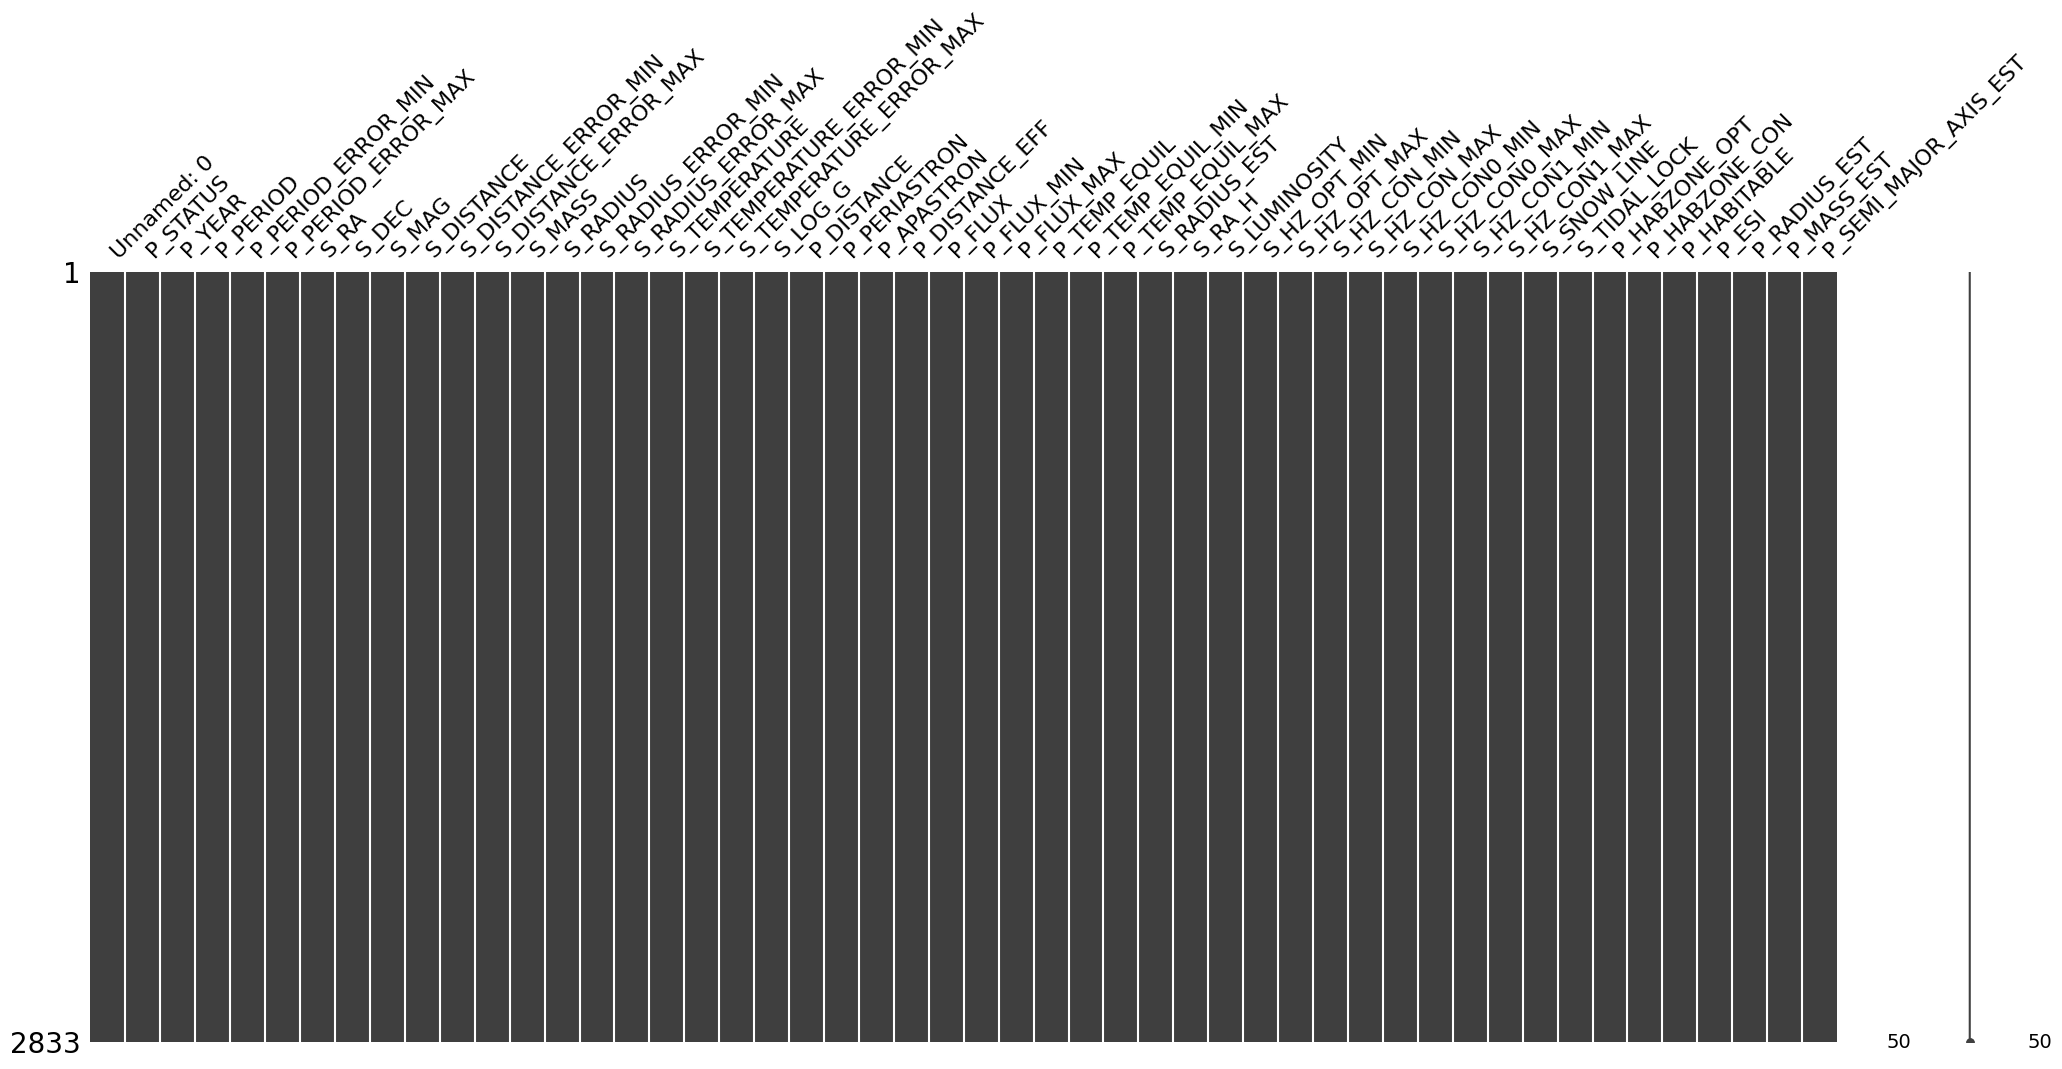

In [9]:
msno.matrix(treated_train)

A linha abaixo mostra os 1215 dados de teste com os valores ausentes já tratados.

<Axes: >

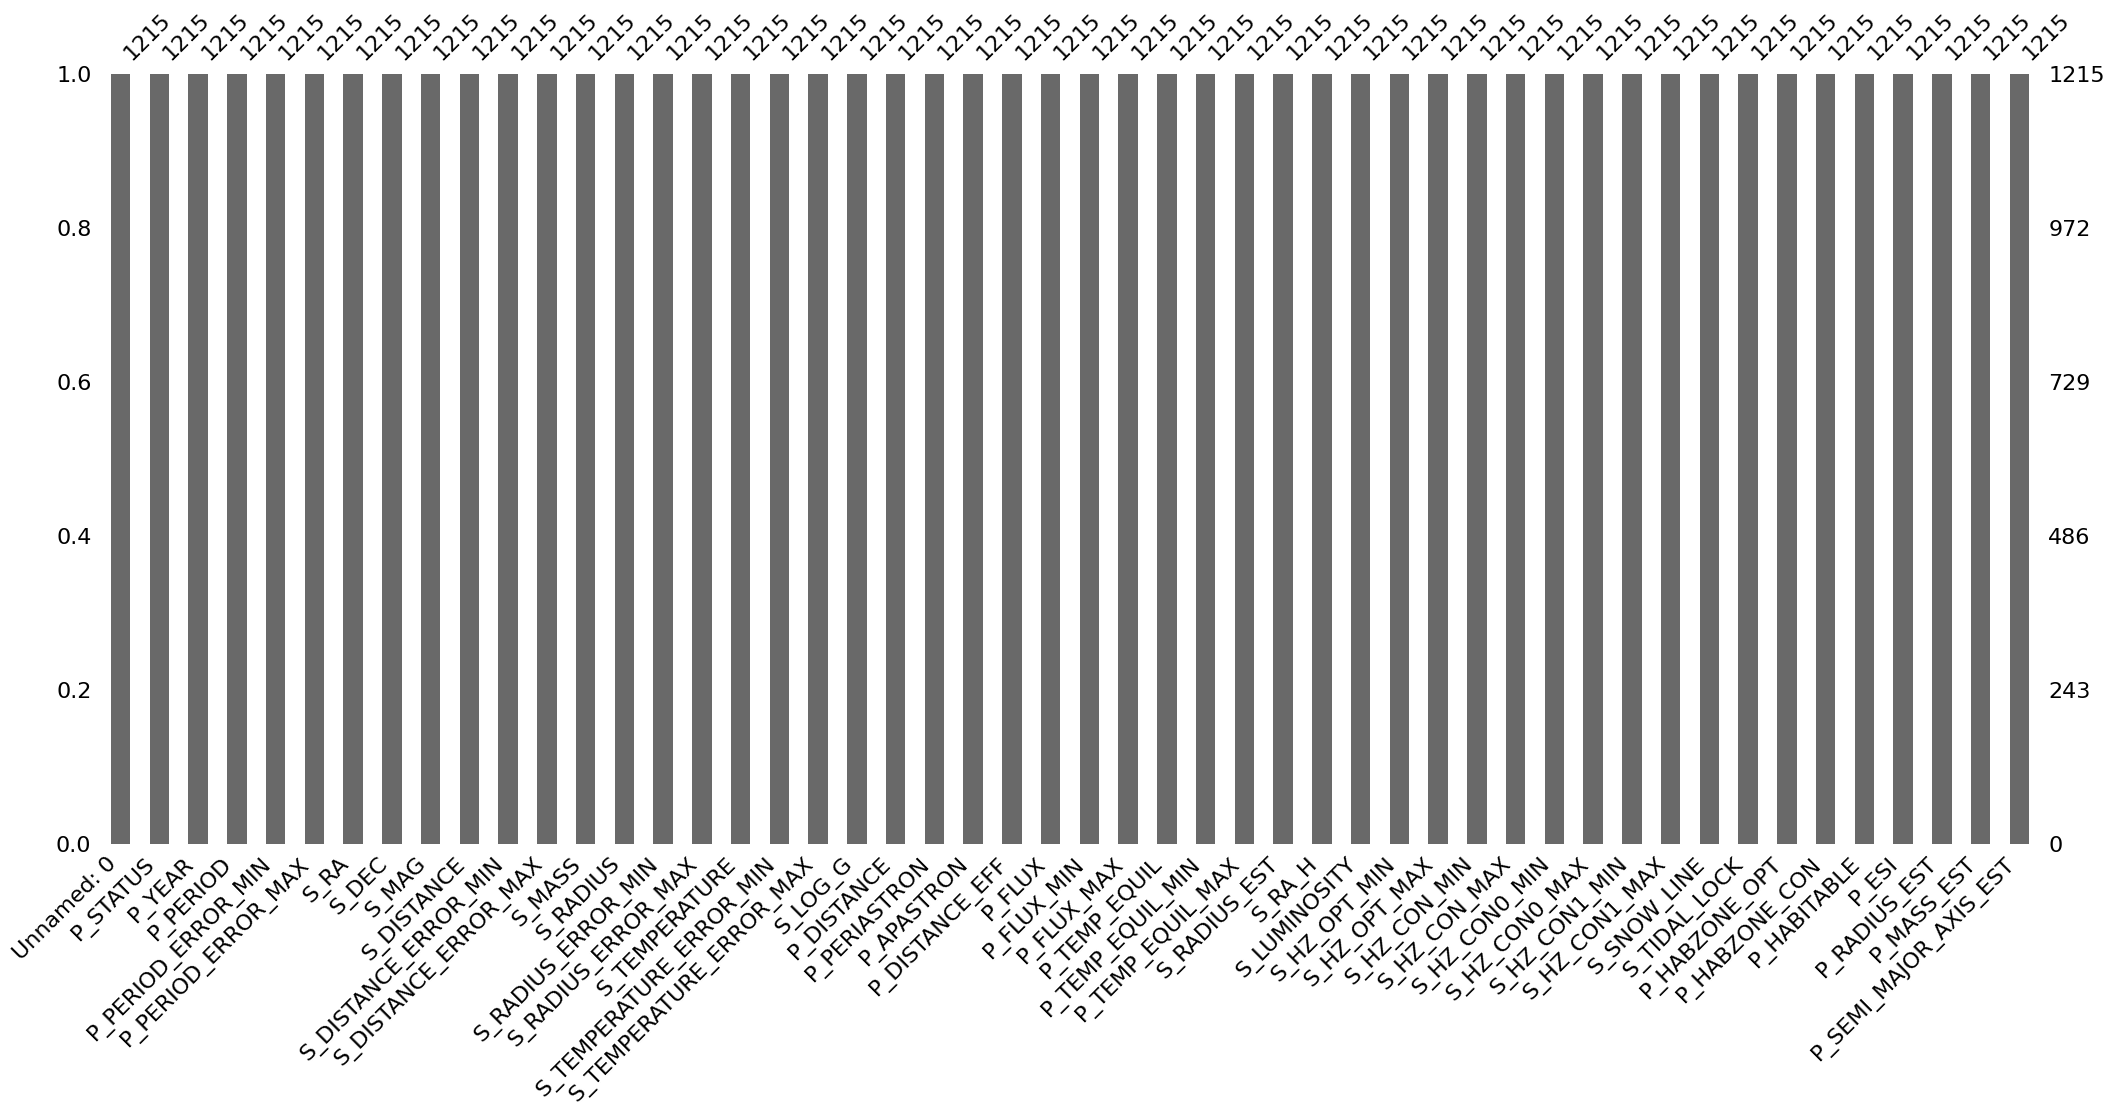

In [10]:
msno.bar(treated_test)

<Axes: title={'center': 'Class Count'}>

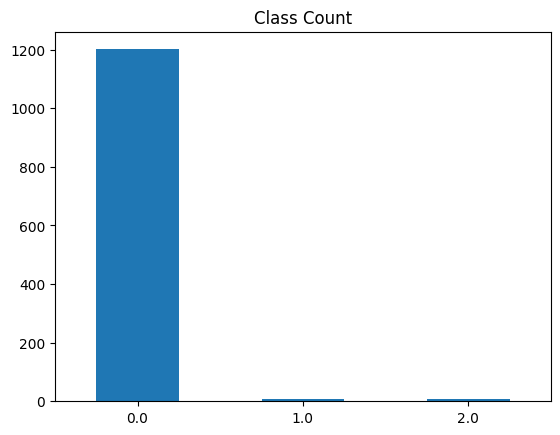

In [11]:
target_count = treated_test['P_HABITABLE'].value_counts()
target_count.plot(kind='bar', title='Class Count', rot=0)

Divisão de variáveis independentes e dependente nos dados de treino

In [12]:
X_Train = treated_train.drop(['P_HABITABLE'], axis=1)
y_Train = treated_train['P_HABITABLE']

Divisão de variáveis independentes e dependente nos dados de teste

In [13]:
X_Test = treated_test.drop(['P_HABITABLE'], axis=1)
y_Test = treated_test['P_HABITABLE']

In [ ]:
# SE for o caso, deletar esta linha da lista, mas se for possível de acordo com o link específico de pipelines armaze-
# nado no Notion, utilizar esta lista para que não seja preciso criar um pipeline para cada modelo, e sim, utilizar a
# lista em um loop for
#models = [model_xgb, model_hgb]

# Exemplo abaixo

# classifiers = [
# KNeighborsClassifier(),
# SVC(),
# LogisticRegression()
# ]

# for clf in classifiers:
# pipe3 = Pipeline([('scaler', StandardScaler()), ('clf',clf)])
# pipe3.fit(X_train, y_train)
# score = pipe3.score(X_test, y_test)
# print(clf)
# print(score)

Numa primeira análise, todos os modelos com a aplicação do smote performaram melhor com os dados de treino, sendo assim, pretendo aplicar o teste de hiperparametros nos seguintes modelos: HGB e XGB com smote

Criar pipeline aqui abaixo (Ler a primeira célula deste notebook para seguir o que deve entrar no pipeline.

In [14]:
cols_drop = ['Unnamed: 0', 'P_STATUS', 'P_YEAR']

def drop_columns(X, cols_to_drop):
    return X.drop(columns=cols_to_drop)

In [15]:
# Criei um pipeline com smote e outro sem (apenas para confirmar qual modelo se sai melhor)
pipe_com_smote = Pipeline([
    ('drop', FunctionTransformer(drop_columns, kw_args={'cols_to_drop': cols_drop})),
    ('smote', SMOTE(random_state=0)),
    ('scaler', MinMaxScaler()),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=4))),
    ('model_xgb', XGBClassifier())
])

pipe_sem_smote = Pipeline(steps=[
    ('drop', FunctionTransformer(drop_columns, kw_args={'cols_to_drop': cols_drop})),
    ('scaler', MinMaxScaler()),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=4))),
    ('model_xgb', XGBClassifier())
])

pipe2_com_smote = Pipeline(steps=[
    ('drop', FunctionTransformer(drop_columns, kw_args={'cols_to_drop': cols_drop})),
    ('smote', SMOTE(random_state=0)),
    ('scaler', MinMaxScaler()),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=4))),
    ('model_hgb', HistGradientBoostingClassifier())
])

pipe2_sem_smote = Pipeline(steps=[
    ('drop', FunctionTransformer(drop_columns, kw_args={'cols_to_drop': cols_drop})),
    ('scaler', MinMaxScaler()),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=4))),
    ('model_hgb', HistGradientBoostingClassifier())
])

In [16]:
pipe_com_smote_scores = cross_val_score(pipe_com_smote, X_Train, y_Train, cv=5)
pipe_sem_smote_scores = cross_val_score(pipe_sem_smote, X_Train, y_Train, cv=5)
pipe2_com_smote_scores = cross_val_score(pipe2_com_smote, X_Train, y_Train, cv=5)
pipe2_sem_smote_scores = cross_val_score(pipe2_sem_smote, X_Train, y_Train, cv=5)

In [17]:
pipe_com_smote_scores.mean()

0.9985878188469473

In [18]:
pipe_sem_smote_scores.mean()

0.9982350851608803

In [19]:
pipe2_com_smote_scores.mean()


0.9978823514748132

In [20]:
pipe2_sem_smote_scores.mean()

0.9858800580826493

In [21]:
# Com PCA

pipe_pca_com_smote = Pipeline(steps=[
    ('drop', FunctionTransformer(drop_columns, kw_args={'cols_to_drop': cols_drop})),
    ('smote', SMOTE(random_state=0)),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=13)),
    ('model_xgb', XGBClassifier())
])

pipe_pca_sem_smote = Pipeline(steps=[
    ('drop', FunctionTransformer(drop_columns, kw_args={'cols_to_drop': cols_drop})),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=13)),
    ('model_xgb', XGBClassifier())
])

pipe2_pca_com_smote = Pipeline(steps=[
    ('drop', FunctionTransformer(drop_columns, kw_args={'cols_to_drop': cols_drop})),
    ('smote', SMOTE(random_state=0)),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=13)),
    ('model_hgb', HistGradientBoostingClassifier())
])

pipe2_pca_sem_smote = Pipeline(steps=[
    ('drop', FunctionTransformer(drop_columns, kw_args={'cols_to_drop': cols_drop})),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=13)),
    ('model_hgb', HistGradientBoostingClassifier())
])

In [22]:
pipe_pca_com_smote_scores = cross_val_score(pipe_pca_com_smote, X_Train, y_Train, cv=5)
pipe_pca_sem_smote_scores = cross_val_score(pipe_pca_sem_smote, X_Train, y_Train, cv=5)
pipe2_pca_com_smote_scores = cross_val_score(pipe2_pca_com_smote, X_Train, y_Train, cv=5)
pipe2_pca_sem_smote_scores = cross_val_score(pipe2_pca_sem_smote, X_Train, y_Train, cv=5)

In [23]:
pipe_pca_com_smote_scores.mean()

0.9929397174391286

In [24]:
pipe_pca_sem_smote_scores.mean()

0.9922348732713868

In [25]:
pipe2_pca_com_smote_scores.mean()

0.9925869837530614

In [26]:
pipe2_pca_sem_smote_scores.mean()

0.9908226921183341

Hiperparametrizar o modelo escolhido

In [27]:
param_distrib = {
    'max_depth': stats.randint(1, 10),
    'learning_rate': stats.uniform(0.01, 0.3),
    'subsample': stats.uniform(0.5, 1),
    'n_estimators':stats.randint(10, 200)
}

In [28]:
xgb_model = XGBClassifier()

In [29]:
xgb_rand_search_cv = RandomizedSearchCV(xgb_model, param_distributions=param_distrib, n_iter=10, cv=5, verbose=1, scoring='accuracy', random_state=3)

In [30]:
xgb_rand_search_cv.fit(X_Train, y_Train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
   

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7cd4d5b13be0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cd4d5b13550>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cd4ef576d70>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7cd4d5b13850>},
                   random_state=3, scoring='accuracy', verbose=1)

In [31]:
print(f"Acuracia Random Search CV LR: {xgb_rand_search_cv.best_score_}")

Acuracia Random Search CV LR: 0.9982357083652726


In [32]:
print("Best set of hyperparameters: ", xgb_rand_search_cv.best_params_)

Best set of hyperparameters:  {'learning_rate': 0.27791953158670196, 'max_depth': 5, 'n_estimators': 38, 'subsample': 0.642717329206941}


In [33]:
pipe_com_smote.named_steps['model_xgb'].set_params(**xgb_rand_search_cv.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.27791953158670196,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=38, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [34]:
pipe_com_smote.fit(X_Train, y_Train)

Pipeline(steps=[('drop',
                 FunctionTransformer(func=<function drop_columns at 0x7cd4d5af3490>,
                                     kw_args={'cols_to_drop': ['Unnamed: 0',
                                                               'P_STATUS',
                                                               'P_YEAR']})),
                ('smote', SMOTE(random_state=0)), ('scaler', MinMaxScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=4))),
                ('model_xgb',
                 XGBClassifier(base_score=None, booster=None...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.27791953158670196, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=38,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [35]:
prediction = pipe_com_smote.predict(X_Test)

Print the prediction accuracy

In [36]:
print(metrics.accuracy_score(y_Test, prediction))

0.9958847736625515


In [37]:
# Esta etapa é executada apenas após o fit do pipeline
selected_features = pipe_com_smote.named_steps['feature_selection'].get_support()

In [38]:
feature_names = X_Train.columns

In [39]:
selected_feature_names = [feature_names[i] for i, selected in enumerate(selected_features) if selected]
print(f'Features selecionadas: {selected_feature_names}')

Features selecionadas: ['S_TEMPERATURE_ERROR_MAX', 'P_DISTANCE', 'P_PERIASTRON', 'P_APASTRON', 'P_DISTANCE_EFF', 'P_FLUX', 'P_FLUX_MIN', 'P_FLUX_MAX', 'P_TEMP_EQUIL', 'S_HZ_CON1_MAX', 'S_TIDAL_LOCK', 'P_HABZONE_OPT', 'P_HABZONE_CON']


Imagino que, se eu tivesse uma maior informação a respeito da importancia de cada feature para o trabalho de detecção de exoplanetas potencialmente habitáveis, poderia melhorar o modelo e torná-lo mais prático

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [ ]:
conf_rf = confusion_matrix(y_Test, prediction)

def conf_matrix(x):
    plt.figure(dpi=125)
    class_labels = ['Classe 0', 'Classe 1', 'Classe 2']
    sns.heatmap(x, annot=True, fmt='d', cmap=plt.cm.Blues, square=True, xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel('Predicted planets')
    plt.ylabel('Actual planets')

In [ ]:
conf_matrix(conf_rf)
plt.title('Confusion Matrix of Random Forest')

NameError: name 'plt' is not defined

In [41]:
f1 = f1_score(y_Test, prediction, average='macro')

In [42]:
print("F1-Score:", f1)

F1-Score: 0.8210938330675174


In [44]:
precision = precision_score(y_Test, prediction, average="macro")

In [45]:
recall = recall_score(y_Test, prediction, average="macro")

In [46]:
print("Precision:", precision)

Precision: 0.8611111111111112


In [47]:
print("Recall:", recall)

Recall: 0.8565877641647832


In [49]:
pickle.dump(pipe_com_smote, open('saved_exoplanets_pipe.pkl', 'wb'))

In [50]:
pipe_model = pipe_com_smote

joblib.dump(pipe_model, 'saved_exoplanets_pipe.joblib')

['saved_exoplanets_pipe.joblib']

In [ ]:
pd.Series(selected_feature_names.feature_importances_.ravel()).hist()

AttributeError: 'list' object has no attribute 'feature_importances_'